In [182]:
import geopandas as gpd
import pandas as pd
import rasterio
from rasterio.features import shapes
import rioxarray
import matplotlib.pyplot as plt
import numpy as np
from skimage.segmentation import slic
from shapely.geometry import shape
from rasterstats import zonal_stats

%matplotlib inline

%load_ext autoreload
%autoreload 2

from gridflow import model
from gridflow.visuals import country_viz

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Demo notebook
This notebook demonstrates the capabilities of the gridflow package. 

In [186]:
countries = ["TUR", "SYR"]

In [187]:
levant = model.region(countries, "data/global_datasets")
levant.create_zones(n=5)

In [188]:
levant.create_network()

/Users/mohini/opt/anaconda3/lib/python3.7/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


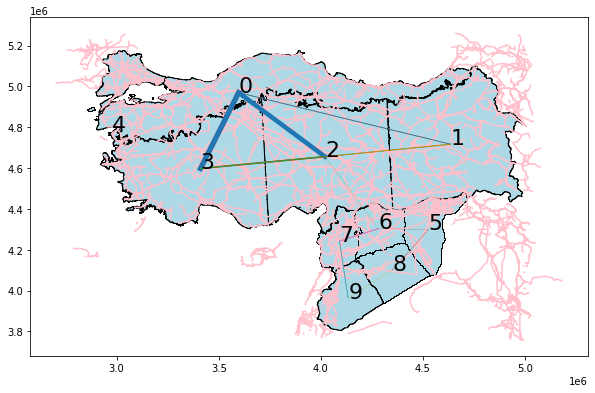

In [189]:
country_viz(levant)